# Implicit Rank-Minmizing Autoencoder
IRMAE paper: [https://arxiv.org/abs/2010.00679](https://arxiv.org/abs/2010.00679)

Implicit Bias of Gradient Descent of Linear Convolutional Networks: [https://arxiv.org/abs/1806.00468](https://arxiv.org/abs/1806.00468)

![irmae_diagram](notes/irmae_diagram.png)

## Import modules 

In [1]:
import os 
import numpy as np 
from sklearn.model_selection import train_test_split
from scipy.linalg import svd

import tensorflow as tf 
from tensorflow import keras
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## Load data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale data 
X_train, X_test = X_train/255, X_test/255

# Add channel dim 
X_train, X_test = X_train[...,np.newaxis], X_test[...,np.newaxis]

# Resize
X_train = tf.image.resize(X_train,(32,32)).numpy()
X_test = tf.image.resize(X_test,(32,32)).numpy()

# One-hot encode target 
y_train = tf.one_hot(y_train, 10).numpy()
y_test = tf.one_hot(y_test, 10).numpy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (48000, 32, 32, 1)
y_train shape: (48000, 10)
X_val shape: (12000, 32, 32, 1)
y_val shape: (12000, 10)
X_test shape: (10000, 32, 32, 1)
y_test shape: (10000, 10)


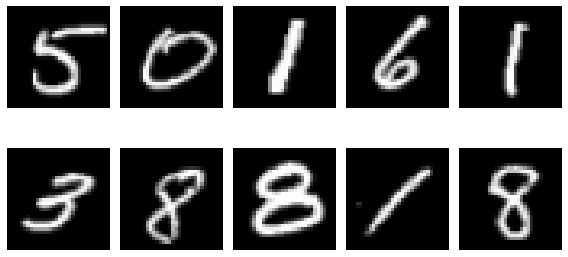

In [3]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 2
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i).set_axis_off()
    plt.imshow(X_train[j,:,:,:],cmap='gray')
    plt.tight_layout()
    j += 1
plt.tight_layout()
plt.show()

## Model 

In [4]:
class AutoEncoder(keras.Model):
    def __init__(self, input_shape,latent_dim=144,c_intial=8):
        super(AutoEncoder, self).__init__()
        self.c_intial = c_intial 
        self.latent_dim = latent_dim
        self.reshape_dim = int(sqrt(latent_dim))
        
        self.encoder = self.getEncoder(input_shape)
        self.decoder = self.getDecoder(self.latent_dim)
        print(self.encoder.summary())
        print(self.decoder.summary())
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def getEncoder(self,input_shape):
        inputs = tf.keras.Input(shape=input_shape)
        x = tf.keras.layers.Conv2D(self.c_intial ,4,strides=(2, 2),activation='relu')(inputs)
        x = tf.keras.layers.Conv2D(self.c_intial*2 ,4,strides=(2, 2),activation='relu')(x)
        x = tf.keras.layers.Conv2D(self.c_intial*4 ,1,strides=(1, 1),activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        z = tf.keras.layers.Dense(self.latent_dim, activation='linear')(x)
        encoder = tf.keras.Model(inputs, [z])
        return encoder

    def getDecoder(self,input_shape):
        inputs = tf.keras.Input(shape=input_shape)
        x = tf.keras.layers.Reshape((self.reshape_dim,self.reshape_dim,1))(inputs)
        x = tf.keras.layers.Conv2DTranspose(self.c_intial*2 ,4,strides=(2, 2),activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(self.c_intial*4 ,5,strides=(1, 1),activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(1,3,strides=(1, 1),activation='sigmoid')(x)
        decoder = tf.keras.Model(inputs, [x])
        return decoder

    def call(self,inputs):
        z = self.encoder(inputs)
        Xh = self.decoder(z)
        return Xh, z
        
    def train_step(self, inputs):
        X,_ = inputs
        with tf.GradientTape() as tape:
            z = self.encoder(X)
            Xh = self.decoder(z)
            loss = tf.keras.losses.MSE(X,Xh)
            
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)
        
        return {
            "mse": self.loss_tracker.result(),
        }
    
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def test_step(self, inputs):
        X,_ = inputs
        z = self.encoder(X)
        Xh = self.decoder(z)
        loss = tf.keras.losses.MSE(X,Xh)
        self.loss_tracker.update_state(loss)
        return {
            "mse": self.loss_tracker.result(),
        }

## Fit AutoEncoder

In [5]:
ae = AutoEncoder((32,32,1))
ae.compile(optimizer='adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 8)         136       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          544       
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 144)               166032    
Total params: 168,776
Trainable params: 168,776
Non-trainable params: 0
_______________________________________________________

In [6]:
history = ae.fit(X_train, X_train, validation_data=(X_val, X_val),\
                    epochs=10, batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 70s 46ms/step - mse: 0.0355 - val_mse: 0.0027
Epoch 2/10
1500/1500 [==============================] - 76s 50ms/step - mse: 0.0024 - val_mse: 0.0018
Epoch 3/10
1500/1500 [==============================] - 76s 51ms/step - mse: 0.0017 - val_mse: 0.0015
Epoch 4/10
1500/1500 [==============================] - 76s 51ms/step - mse: 0.0014 - val_mse: 0.0013
Epoch 5/10
1500/1500 [==============================] - 72s 48ms/step - mse: 0.0012 - val_mse: 0.0011
Epoch 6/10
1500/1500 [==============================] - 72s 48ms/step - mse: 0.0011 - val_mse: 0.0010
Epoch 7/10
1500/1500 [==============================] - 72s 48ms/step - mse: 0.0010 - val_mse: 9.7687e-04
Epoch 8/10
1500/1500 [==============================] - 73s 49ms/step - mse: 9.6309e-04 - val_mse: 9.3752e-04
Epoch 9/10
1500/1500 [==============================] - 72s 48ms/step - mse: 9.0700e-04 - val_mse: 8.7693e-04
Epoch 10/10
1500/1500 [==============================] - 72s 4

## Fit IRMAE

In [7]:
class IRMAE(keras.Model):
    def __init__(self, input_shape,latent_dim=144,c_intial=8,n_layers=2):
        super(IRMAE, self).__init__()
        self.c_intial = c_intial 
        self.latent_dim = latent_dim
        self.reshape_dim = int(sqrt(latent_dim))
        
        self.encoder = self.getEncoder(input_shape)
        self.denseBlock = self.getDenseBlock(self.latent_dim,n_layers)
        self.decoder = self.getDecoder(self.latent_dim)
        print(self.encoder.summary())
        print(self.denseBlock.summary())
        print(self.decoder.summary())
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def getEncoder(self,input_shape):
        inputs = tf.keras.Input(shape=input_shape)
        x = tf.keras.layers.Conv2D(self.c_intial ,4,strides=(2, 2),activation='relu')(inputs)
        x = tf.keras.layers.Conv2D(self.c_intial*2 ,4,strides=(2, 2),activation='relu')(x)
        x = tf.keras.layers.Conv2D(self.c_intial*4 ,1,strides=(1, 1),activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        z = tf.keras.layers.Dense(self.latent_dim, activation='linear')(x)
        encoder = tf.keras.Model(inputs, [z])
        return encoder
    
    def getDenseBlock(self,input_shape,n_layers):
        inputs = tf.keras.Input(shape=input_shape)
        for i in range(n_layers):
            if i == 0:
                x = tf.keras.layers.Dense(input_shape, activation='linear',use_bias=False)(inputs)
            else:
                x = tf.keras.layers.Dense(input_shape, activation='linear',use_bias=False)(x)
        linearblock = tf.keras.Model(inputs, [x])
        return linearblock

    def getDecoder(self,input_shape):
        inputs = tf.keras.Input(shape=input_shape)
        x = tf.keras.layers.Reshape((self.reshape_dim,self.reshape_dim,1))(inputs)
        x = tf.keras.layers.Conv2DTranspose(self.c_intial*2 ,4,strides=(2, 2),activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(self.c_intial*4 ,5,strides=(1, 1),activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(1,3,strides=(1, 1),activation='sigmoid')(x)
        decoder = tf.keras.Model(inputs, [x])
        return decoder
        
    def call(self,inputs):
        z = self.encoder(inputs)
        z = self.denseBlock(z)
        Xh = self.decoder(z)
        return Xh, z
        
    def train_step(self, inputs):
        X,_ = inputs
        with tf.GradientTape() as tape:
            z = self.encoder(X)
            z = self.denseBlock(z)
            Xh = self.decoder(z)
            loss = tf.keras.losses.MSE(X,Xh)
            
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)
        
        return {
            "mse": self.loss_tracker.result(),
        }
    
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def test_step(self, inputs):
        X,_ = inputs
        z = self.encoder(X)
        z = self.denseBlock(z)
        Xh = self.decoder(z)
        loss = tf.keras.losses.MSE(X,Xh)
        self.loss_tracker.update_state(loss)
        return {
            "mse": self.loss_tracker.result(),
        }

In [8]:
irmae = IRMAE((32,32,1))
irmae.compile(optimizer='adam')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         136       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 16)          2064      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 32)          544       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 144)               166032    
Total params: 168,776
Trainable params: 168,776
Non-trainable params: 0
_____________________________________________________

In [9]:
history = irmae.fit(X_train, X_train, validation_data=(X_val, X_val),\
                    epochs=10, batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 72s 48ms/step - mse: 0.0362 - val_mse: 0.0030
Epoch 2/10
1500/1500 [==============================] - 71s 47ms/step - mse: 0.0026 - val_mse: 0.0019
Epoch 3/10
1500/1500 [==============================] - 71s 47ms/step - mse: 0.0018 - val_mse: 0.0015
Epoch 4/10
1500/1500 [==============================] - 71s 47ms/step - mse: 0.0015 - val_mse: 0.0013
Epoch 5/10
1500/1500 [==============================] - 71s 47ms/step - mse: 0.0013 - val_mse: 0.0013
Epoch 6/10
1500/1500 [==============================] - 73s 49ms/step - mse: 0.0012 - val_mse: 0.0012
Epoch 7/10
1500/1500 [==============================] - 73s 48ms/step - mse: 0.0011 - val_mse: 0.0011
Epoch 8/10
1500/1500 [==============================] - 72s 48ms/step - mse: 0.0010 - val_mse: 0.0010
Epoch 9/10
1500/1500 [==============================] - 72s 48ms/step - mse: 9.8047e-04 - val_mse: 9.7061e-04
Epoch 10/10
1500/1500 [==============================] - 73s 48ms/step - m

## Compare Rank of Latent Space

In [10]:
_ ,z_val_ae = ae(X_val)
_ ,z_val_irmae = irmae(X_val)

In [11]:
_, ae_z_singluar_values, _ = svd(z_val_ae.numpy())
_, irmae_z_singluar_values, _ = svd(z_val_irmae.numpy())

In [12]:
ae_z_singluar_values_scaled = ae_z_singluar_values/np.max(ae_z_singluar_values)
irmae_z_singluar_values_scaled = irmae_z_singluar_values/np.max(irmae_z_singluar_values)

ae_z_singluar_values_scaled[::-1].sort()
irmae_z_singluar_values_scaled[::-1].sort()

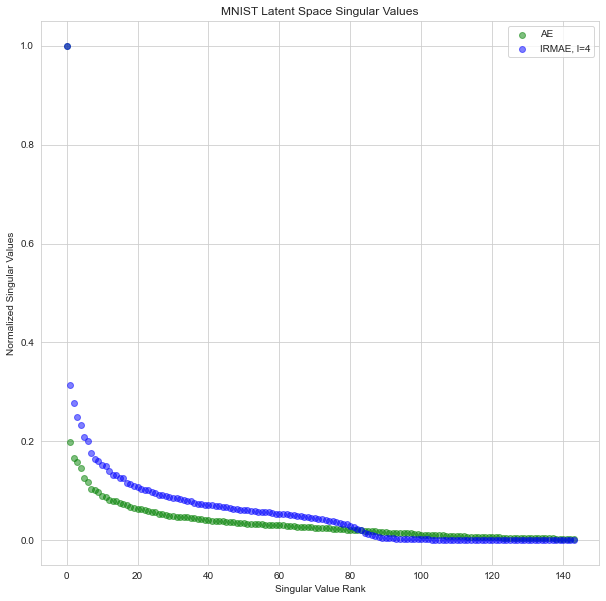

In [14]:
x_ticks = np.arange(0,len(ae_z_singluar_values_scaled))
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x_ticks, ae_z_singluar_values_scaled,label='AE',color='g',alpha=.5)
ax.scatter(x_ticks, irmae_z_singluar_values_scaled,label='IRMAE, l=4',color='b',alpha=.5)

ax.set(xlabel='Singular Value Rank', ylabel='Normalized Singular Values',
       title='MNIST Latent Space Singular Values')
ax.legend()